##### Импорт библиотек

In [1]:
# pylint: disable=import-error,wrong-import-order,unused-import
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score 
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import warnings
import numpy as np
import xgboost as xgb
from lightgbm import LGBMRegressor
import os

os.makedirs('models', exist_ok=True)

# Отключаем логи LightGBM
import logging
logging.getLogger('lightgbm').setLevel(logging.WARNING)

print("Библиотеки загружены!\n")

df = pd.read_csv('df/obr.csv', parse_dates=['datetime'], index_col='datetime')
print(f"Данные загружены: {df.shape}")

Библиотеки загружены!

Данные загружены: (260640, 14)


In [2]:
# УЛУЧШЕННОЕ СОЗДАНИЕ ПРИЗНАКОВ НА ОСНОВЕ EDA
print("Создание УЛУЧШЕННЫХ признаков на основе EDA анализа...")
print(f"Исходный размер: {df.shape}")

# ===== ОСНОВНЫЕ ВРЕМЕННЫЕ ПРИЗНАКИ =====
# Циклические признаки
df['hour_sin'] = np.sin(2 * np.pi * df['hour']/24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour']/24)
df['month_sin'] = np.sin(2 * np.pi * df['month']/12)
df['month_cos'] = np.cos(2 * np.pi * df['month']/12)
df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week']/7)
df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week']/7)

# ===== ПРИЗНАКИ ИЗ EDA АНАЛИЗА =====
# 1. СУТОЧНЫЕ ПАТТЕРНЫ (из анализа часов)
df['is_early_morning'] = ((df['hour'] >= 4) & (df['hour'] <= 6)).astype(int)  # Подъем
df['is_midday'] = ((df['hour'] >= 10) & (df['hour'] <= 16)).astype(int)       # День
df['is_late_evening'] = ((df['hour'] >= 21) & (df['hour'] <= 23)).astype(int) # Поздний вечер

# Сохраняем основные пиковые периоды из EDA
df['is_evening_peak'] = ((df['hour'] >= 18) & (df['hour'] <= 22)).astype(int)
df['is_morning_peak'] = ((df['hour'] >= 7) & (df['hour'] <= 9)).astype(int)
df['is_night'] = ((df['hour'] >= 0) & (df['hour'] <= 5)).astype(int)

# 2. НЕДЕЛЬНЫЕ ПАТТЕРНЫ (из анализа дней) - УЧИТЫВАЕМ +36.6% разницу!
df['is_monday'] = (df['day_of_week'] == 0).astype(int)      # Начало недели
df['is_friday'] = (df['day_of_week'] == 4).astype(int)      # Конец недели
df['is_sunday'] = (df['day_of_week'] == 6).astype(int)      # Воскресенье - максимум потребления
df['weekend_evening_boost'] = (df['is_weekend'] & df['is_evening_peak']).astype(int)
df['weekend_morning'] = (df['is_weekend'] & df['is_morning_peak']).astype(int)

# 3. МЕСЯЧНЫЕ/СЕЗОННЫЕ ПАТТЕРНЫ (из анализа месяцев) - УЧИТЫВАЕМ -43.9% зимой!
# Зимние месяцы (высокое потребление) - январь, февраль, декабрь
df['is_high_season'] = df['month'].isin([1, 2, 12]).astype(int)  # Зима
# Летние месяцы (низкое потребление) - июнь, июль, август
df['is_low_season'] = df['month'].isin([6, 7, 8]).astype(int)    # Лето
# Переходные месяцы
df['is_spring'] = df['month'].isin([3, 4, 5]).astype(int)        # Весна

# 4. КРИТИЧЕСКИЕ ПЕРИОДЫ ИЗ EDA
# Периоды максимального роста/спада (из анализа динамики)
df['morning_surge_6_7'] = ((df['hour'] >= 6) & (df['hour'] <= 7)).astype(int)  # Рост с 6 до 7
df['evening_surge_17_18'] = ((df['hour'] >= 17) & (df['hour'] <= 18)).astype(int)  # Рост с 17 до 18
df['evening_drop_22_23'] = ((df['hour'] >= 22) & (df['hour'] <= 23)).astype(int)   # Спад с 22 до 23

# 5. ВЗАИМОДЕЙСТВИЯ ПРИЗНАКОВ НА ОСНОВЕ EDA
df['winter_evening'] = (df['is_high_season'] & df['is_evening_peak']).astype(int)
df['summer_afternoon'] = (df['is_low_season'] & df['is_midday']).astype(int)
df['workday_evening'] = ((~df['is_weekend']) & df['is_evening_peak']).astype(int)
df['sunday_evening'] = (df['is_sunday'] & df['is_evening_peak']).astype(int)

# ===== УМНЫЕ ЛАГИ НА ОСНОВЕ АВТОКОРРЕЛЯЦИИ =====
# Используем стратегические лаги на основе анализа ACF/PACF
df['lag_same_day_24h'] = df['Global_active_power'].shift(24)        # Вчера в это же время
df['lag_week_ago_168h'] = df['Global_active_power'].shift(24*7)     # Неделю назад в это же время
df['lag_2h_ago'] = df['Global_active_power'].shift(2)               # 2 часа назад
df['lag_6h_ago'] = df['Global_active_power'].shift(6)               # 6 часов назад
df['lag_12h_ago'] = df['Global_active_power'].shift(12)             # 12 часов назад

# ===== СКОЛЬЗЯЩИЕ СТАТИСТИКИ БЕЗ УТЕЧЕК =====
# Используем ТОЛЬКО прошлые данные для избежания утечек
df['rolling_mean_24h_past'] = df['Global_active_power'].shift(1).rolling(window=24, min_periods=1).mean()
df['rolling_std_24h_past'] = df['Global_active_power'].shift(1).rolling(window=24, min_periods=1).std()
df['rolling_mean_7d_past'] = df['Global_active_power'].shift(1).rolling(window=24*7, min_periods=1).mean()
df['rolling_mean_3h_past'] = df['Global_active_power'].shift(1).rolling(window=3, min_periods=1).mean()

# ===== ПРИЗНАКИ ИЗ СУБ-СЧЕТЧИКОВ =====
# Относительное потребление по зонам
df['total_sub_metering'] = df['Sub_metering_1'] + df['Sub_metering_2'] + df['Sub_metering_3']
df['kitchen_ratio'] = df['Sub_metering_1'] / (df['total_sub_metering'] + 0.001)
df['laundry_ratio'] = df['Sub_metering_2'] / (df['total_sub_metering'] + 0.001)
df['ac_heating_ratio'] = df['Sub_metering_3'] / (df['total_sub_metering'] + 0.001)

# Активность по зонам (бинарные признаки)
df['kitchen_active'] = (df['Sub_metering_1'] > 0).astype(int)
df['laundry_active'] = (df['Sub_metering_2'] > 0).astype(int)
df['ac_heating_active'] = (df['Sub_metering_3'] > 0).astype(int)

# ===== ДОПОЛНИТЕЛЬНЫЕ ПРИЗНАКИ ИЗ EDA =====
# Периоды минимального потребления (ночь)
df['is_deep_night'] = ((df['hour'] >= 1) & (df['hour'] <= 4)).astype(int)

# Дни с особым паттерном (из анализа недельной сезонности)
df['is_week_start'] = (df['day_of_week'].isin([0, 1])).astype(int)  # Пн-Вт
df['is_week_end'] = (df['day_of_week'].isin([4, 5])).astype(int)    # Пт-Сб

print(f"Создано {len([col for col in df.columns if col not in ['Global_active_power', 'datetime']])} признаков")

# ===== ОБРАБОТКА ПРОПУСКОВ =====
print("Обработка пропусков...")
initial_size = len(df)

# Заполняем пропуски в числовых признаках
numeric_columns = df.select_dtypes(include=[np.number]).columns
for col in numeric_columns:
    if df[col].isnull().any():
        # Для лагов и скользящих - заполняем предыдущими значениями
        if 'lag' in col or 'rolling' in col:
            df[col] = df[col].ffill().bfill()
        else:
            df[col] = df[col].fillna(df[col].median())

# Удаляем оставшиеся пропуски
df = df.dropna()

print(f"Признаки созданы. Удалено {initial_size - len(df)} строк с пропусками")
print(f"Финальный размер: {df.shape}")
print(f"Колонки ({len(df.columns)}): {list(df.columns)}")

Создание УЛУЧШЕННЫХ признаков на основе EDA анализа...
Исходный размер: (260640, 14)
Создано 56 признаков
Обработка пропусков...
Признаки созданы. Удалено 0 строк с пропусками
Финальный размер: (260640, 57)
Колонки (57): ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'hour', 'day_of_week', 'month', 'is_weekend', 'is_morning_peak', 'is_evening_peak', 'is_night', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'day_of_week_sin', 'day_of_week_cos', 'is_early_morning', 'is_midday', 'is_late_evening', 'is_monday', 'is_friday', 'is_sunday', 'weekend_evening_boost', 'weekend_morning', 'is_high_season', 'is_low_season', 'is_spring', 'morning_surge_6_7', 'evening_surge_17_18', 'evening_drop_22_23', 'winter_evening', 'summer_afternoon', 'workday_evening', 'sunday_evening', 'lag_same_day_24h', 'lag_week_ago_168h', 'lag_2h_ago', 'lag_6h_ago', 'lag_12h_ago', 'rolling_mean_24h_past', 'rolling_std_24h_past', 'rol

In [3]:
df.sample(5)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,hour,day_of_week,month,...,total_sub_metering,kitchen_ratio,laundry_ratio,ac_heating_ratio,kitchen_active,laundry_active,ac_heating_active,is_deep_night,is_week_start,is_week_end
datetime,,,,,,,,,,,,,,,,,,,,,
2007-06-24 11:35:00,0.302,0.228,237.32,1.6,0.0,2.0,0.0,11,6,6,...,2.0,0.0,0.999500,0.000000,0,1,0,0,0,0
2007-04-10 21:14:00,1.052,0.138,238.82,4.6,0.0,1.0,0.0,21,1,4,...,1.0,0.0,0.999001,0.000000,0,1,0,0,1,0
2007-03-03 20:25:00,1.878,0.046,237.60,7.8,0.0,0.0,17.0,20,5,3,...,17.0,0.0,0.000000,0.999941,0,0,1,0,0,1
2007-06-07 03:34:00,0.336,0.192,234.57,1.6,0.0,1.0,0.0,3,3,6,...,1.0,0.0,0.999001,0.000000,0,1,0,1,0,0
2007-03-29 02:48:00,0.322,0.142,245.60,1.4,0.0,0.0,0.0,2,3,3,...,0.0,0.0,0.000000,0.000000,0,0,0,1,0,0


In [4]:
# ПОДГОТОВКА ДАННЫХ ДЛЯ ОБУЧЕНИЯ
print("Подготовка данных...")

# Целевая переменная
y = df['Global_active_power']

# ПРИЗНАКИ БЕЗ УТЕЧЕК (исключаем текущие и будущие данные)
safe_features = [
    # === ЦИКЛИЧЕСКИЕ ПРИЗНАКИ ===
    'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'day_of_week_sin', 'day_of_week_cos',
    
    # === СУТОЧНЫЕ ПАТТЕРНЫ ИЗ EDA ===
    'is_early_morning', 'is_midday', 'is_late_evening',
    'is_evening_peak', 'is_morning_peak', 'is_night', 'is_deep_night',
    
    # === НЕДЕЛЬНЫЕ ПАТТЕРНЫ ИЗ EDA (+36.6% разница выходные/рабочие) ===
    'is_monday', 'is_friday', 'is_sunday', 
    'is_week_start', 'is_week_end',
    'weekend_evening_boost', 'weekend_morning',
    
    # === СЕЗОННЫЕ ПАТТЕРНЫ ИЗ EDA (-43.9% зимой) ===
    'is_high_season', 'is_low_season', 'is_spring',
    
    # === КРИТИЧЕСКИЕ ПЕРИОДЫ ИЗ EDA ===
    'morning_surge_6_7', 'evening_surge_17_18', 'evening_drop_22_23',
    
    # === ВЗАИМОДЕЙСТВИЯ ПРИЗНАКОВ ===
    'winter_evening', 'summer_afternoon', 'workday_evening', 'sunday_evening',
    
    # === БЕЗОПАСНЫЕ ЛАГИ (только прошлое) ===
    'lag_same_day_24h', 'lag_week_ago_168h', 'lag_2h_ago', 'lag_6h_ago', 'lag_12h_ago',
    
    # === БЕЗОПАСНЫЕ СКОЛЬЗЯЩИЕ СТАТИСТИКИ (только прошлое) ===
    'rolling_mean_24h_past', 'rolling_std_24h_past', 'rolling_mean_7d_past', 'rolling_mean_3h_past',
    
    # === ПРИЗНАКИ ИЗ СУБ-СЧЕТЧИКОВ ===
    'kitchen_ratio', 'laundry_ratio', 'ac_heating_ratio',
    'kitchen_active', 'laundry_active', 'ac_heating_active',
    
    # === БАЗОВЫЕ ВРЕМЕННЫЕ ПРИЗНАКИ ===
    'hour', 'day_of_week', 'month', 'is_weekend'
]

# ЧЕСТНЫЕ ПРИЗНАКИ БЕЗ УТЕЧЕК (используем только сезонность и долгосрочные лаги)
honest_features = [
    # === ЦИКЛИЧЕСКИЕ ПРИЗНАКИ ===
    'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'day_of_week_sin', 'day_of_week_cos',
    
    # === СУТОЧНЫЕ ПАТТЕРНЫ ИЗ EDA ===
    'is_early_morning', 'is_midday', 'is_late_evening',
    'is_evening_peak', 'is_morning_peak', 'is_night', 'is_deep_night',
    
    # === НЕДЕЛЬНЫЕ ПАТТЕРНЫ ИЗ EDA (+36.6% разница выходные/рабочие) ===
    'is_monday', 'is_friday', 'is_sunday', 
    'is_week_start', 'is_week_end',
    'weekend_evening_boost', 'weekend_morning',
    
    # === СЕЗОННЫЕ ПАТТЕРНЫ ИЗ EDA (-43.9% зимой) ===
    'is_high_season', 'is_low_season', 'is_spring',
    
    # === КРИТИЧЕСКИЕ ПЕРИОДЫ ИЗ EDA ===
    'morning_surge_6_7', 'evening_surge_17_18', 'evening_drop_22_23',
    
    # === ВЗАИМОДЕЙСТВИЯ ПРИЗНАКОВ ===
    'winter_evening', 'summer_afternoon', 'workday_evening', 'sunday_evening',
    
    # === ТОЛЬКО ДОЛГОСРОЧНЫЕ ЛАГИ (без краткосрочных утечек) ===
    'lag_same_day_24h',        # Вчера в это же время
    'lag_week_ago_168h',       # Неделю назад в это же время
    
    # === ПРИЗНАКИ ИЗ СУБ-СЧЕТЧИКОВ ===
    'kitchen_ratio', 'laundry_ratio', 'ac_heating_ratio',
    'kitchen_active', 'laundry_active', 'ac_heating_active',
    
    # === БАЗОВЫЕ ВРЕМЕННЫЕ ПРИЗНАКИ ===
    'hour', 'day_of_week', 'month', 'is_weekend'
]

# УБИРАЕМ ВСЕ СКОЛЬЗЯЩИЕ СТАТИСТИКИ - они создают утечки!
features_to_remove = [
    'rolling_mean_3h_past', 'rolling_mean_24h_past', 'rolling_std_24h_past', 
    'rolling_mean_7d_past', 'lag_2h_ago', 'lag_6h_ago', 'lag_12h_ago'
]

honest_features = [f for f in honest_features if f not in features_to_remove]

# Проверяем, что все признаки существуют в DataFrame
available_features = [f for f in safe_features if f in df.columns]
print(f"Доступно признаков: {len(available_features)} из {len(safe_features)}")

# Убираем признаки с пропусками
df_safe = df[available_features + ['Global_active_power']].dropna()
X = df_safe[available_features]
y = df_safe['Global_active_power']

print(f"\nИспользуем {len(available_features)} безопасных признаков (без утечек):")
print("Типы признаков:")
print(X.dtypes.value_counts())

# Разделение на train/test с учетом времени (ВАЖНО для временных рядов!)
split_index = int(len(df_safe) * 0.8)

X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]

y_train = y.iloc[:split_index] 
y_test = y.iloc[split_index:]

print(f"\nРазделение данных:")
print(f"Обучающая выборка: {X_train.shape[0]} записей")
print(f"Тестовая выборка: {X_test.shape[0]} записей")
print(f"Дата начала train: {X_train.index.min()}")
print(f"Дата конца test: {X_test.index.max()}")
print(f"Период train: {X_train.index.min()} - {X_train.index.max()}")
print(f"Период test: {X_test.index.min()} - {X_test.index.max()}")

# Анализ распределения целевой переменной
print(f"\nСтатистика целевой переменной:")
print(f"Train - Среднее: {y_train.mean():.3f} кВт, Медиана: {y_train.median():.3f} кВт")
print(f"Test  - Среднее: {y_test.mean():.3f} кВт, Медиана: {y_test.median():.3f} кВт")

Подготовка данных...
Доступно признаков: 49 из 49

Используем 49 безопасных признаков (без утечек):
Типы признаков:
int64      31
float64    18
Name: count, dtype: int64

Разделение данных:
Обучающая выборка: 208512 записей
Тестовая выборка: 52128 записей
Дата начала train: 2007-01-01 00:00:00
Дата конца test: 2007-06-30 23:59:00
Период train: 2007-01-01 00:00:00 - 2007-05-25 19:11:00
Период test: 2007-05-25 19:12:00 - 2007-06-30 23:59:00

Статистика целевой переменной:
Train - Среднее: 1.228 кВт, Медиана: 0.656 кВт
Test  - Среднее: 0.870 кВт, Медиана: 0.378 кВт


In [5]:
# ОБУЧЕНИЕ МОДЕЛЕЙ
print("Обучение моделей...")

# Словарь для хранения моделей и результатов
models = {}
results = {}

# A. RANDOM FOREST
print("\nОбучение RandomForest...")
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)
models['RandomForest'] = rf_model

# B. XGBOOST
print("Обучение XGBoost...")
xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=10,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1
)
xgb_model.fit(X_train, y_train)
models['XGBoost'] = xgb_model

# C. LIGHTGBM
print("Обучение LightGBM...")
lgb_model = LGBMRegressor(
    n_estimators=100,
    max_depth=10,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)
lgb_model.fit(X_train, y_train)
models['LightGBM'] = lgb_model

print("Все модели обучены!")

Обучение моделей...

Обучение RandomForest...
Обучение XGBoost...
Обучение LightGBM...
Все модели обучены!



Оценка качества моделей на тестовой выборке:

RandomForest:
  MAE:  0.1032 кВт
  RMSE: 0.2665 кВт
  R²:   0.9263

XGBoost:
  MAE:  0.0941 кВт
  RMSE: 0.2385 кВт
  R²:   0.9409

LightGBM:
  MAE:  0.1010 кВт
  RMSE: 0.2487 кВт
  R²:   0.9358

СРАВНЕНИЕ МОДЕЛЕЙ:
Лучшая модель по MAE: XGBoost

Визуализация результатов...


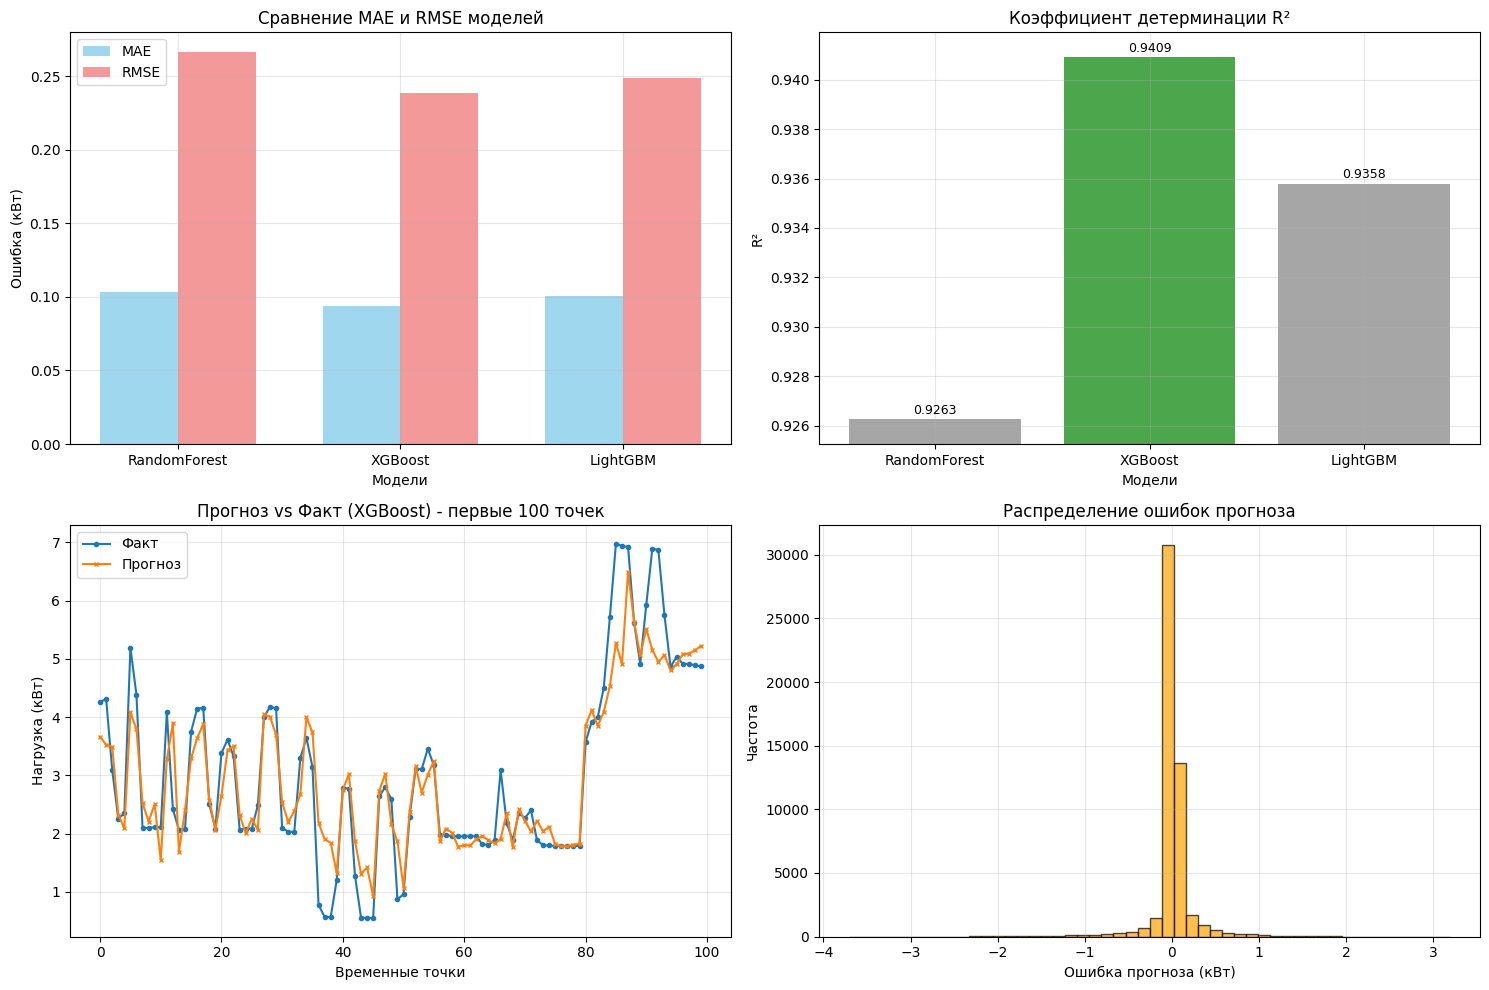


ТАБЛИЦА МЕТРИК:
Модель          MAE (кВт)    RMSE (кВт)   R²        
RandomForest    0.1032       0.2665       0.9263    
XGBoost         0.0941       0.2385       0.9409     
LightGBM        0.1010       0.2487       0.9358    

АНАЛИЗ ЛУЧШЕЙ МОДЕЛИ (XGBoost):
• Средняя ошибка: 94.1 Вт
• Точность прогноза: 94.09%
• Максимальная ошибка: 3705.2 Вт


In [6]:
# ОЦЕНКА КАЧЕСТВА МОДЕЛЕЙ
print("\nОценка качества моделей на тестовой выборке:")

for name, model in models.items():
    # Прогнозы
    y_pred = model.predict(X_test)
    
    # Метрики
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {
        'MAE': mae,
        'RMSE': rmse, 
        'R2': r2,
        'predictions': y_pred
    }
    
    print(f"\n{name}:")
    print(f"  MAE:  {mae:.4f} кВт")
    print(f"  RMSE: {rmse:.4f} кВт") 
    print(f"  R²:   {r2:.4f}")

# Сравнение моделей
print("\nСРАВНЕНИЕ МОДЕЛЕЙ:")
best_model = min(results, key=lambda x: results[x]['MAE'])
print(f"Лучшая модель по MAE: {best_model}")

# ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ
print("\nВизуализация результатов...")

# ГРАФИК СРАВНЕНИЯ МЕТРИК
plt.figure(figsize=(15, 10))

# График 1: Сравнение метрик
plt.subplot(2, 2, 1)
metrics = ['MAE', 'RMSE']
models_names = list(results.keys())
mae_values = [results[model]['MAE'] for model in models_names]
rmse_values = [results[model]['RMSE'] for model in models_names]

x = np.arange(len(models_names))
width = 0.35

plt.bar(x - width/2, mae_values, width, label='MAE', alpha=0.8, color='skyblue')
plt.bar(x + width/2, rmse_values, width, label='RMSE', alpha=0.8, color='lightcoral')

plt.xlabel('Модели')
plt.ylabel('Ошибка (кВт)')
plt.title('Сравнение MAE и RMSE моделей')
plt.xticks(x, models_names)
plt.legend()
plt.grid(True, alpha=0.3)

# График 2: R² сравнение (ИСПРАВЛЕННЫЙ)
plt.subplot(2, 2, 2)
r2_values = [results[model]['R2'] for model in models_names]
colors = ['green' if model == best_model else 'gray' for model in models_names]

# Автоматически подбираем масштаб
r2_min, r2_max = min(r2_values), max(r2_values)
plt.ylim(r2_min - 0.001, r2_max + 0.001)  # Динамический масштаб

plt.bar(models_names, r2_values, color=colors, alpha=0.7)
plt.xlabel('Модели')
plt.ylabel('R²')
plt.title('Коэффициент детерминации R²')
plt.grid(True, alpha=0.3)

# Добавляем значения на столбцы
for i, v in enumerate(r2_values):
    plt.text(i, v + 0.0001, f'{v:.4f}', ha='center', va='bottom', fontsize=9)

# График 3: Прогнозы vs Факт (для лучшей модели)
plt.subplot(2, 2, 3)
best_predictions = results[best_model]['predictions']

# Берем первые 100 точек для наглядности
sample_size = min(100, len(y_test))
plt.plot(y_test.values[:sample_size], label='Факт', marker='o', markersize=3)
plt.plot(best_predictions[:sample_size], label='Прогноз', marker='x', markersize=3)
plt.xlabel('Временные точки')
plt.ylabel('Нагрузка (кВт)')
plt.title(f'Прогноз vs Факт ({best_model}) - первые 100 точек')
plt.legend()
plt.grid(True, alpha=0.3)

# График 4: Ошибки прогноза
plt.subplot(2, 2, 4)
errors = best_predictions - y_test.values
plt.hist(errors, bins=50, alpha=0.7, color='orange', edgecolor='black')
plt.xlabel('Ошибка прогноза (кВт)')
plt.ylabel('Частота')
plt.title('Распределение ошибок прогноза')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ТАБЛИЦА С МЕТРИКАМИ
print("\nТАБЛИЦА МЕТРИК:")
print("="*50)
print(f"{'Модель':<15} {'MAE (кВт)':<12} {'RMSE (кВт)':<12} {'R²':<10}")
print("="*50)
for model in models_names:
    mae = results[model]['MAE']
    rmse = results[model]['RMSE']
    r2 = results[model]['R2']
    marker = " " if model == best_model else ""
    print(f"{model:<15} {mae:<12.4f} {rmse:<12.4f} {r2:<10.4f}{marker}")
print("="*50)

# АНАЛИЗ ЛУЧШЕЙ МОДЕЛИ
print(f"\nАНАЛИЗ ЛУЧШЕЙ МОДЕЛИ ({best_model}):")
best_mae = results[best_model]['MAE']
best_rmse = results[best_model]['RMSE']
best_r2 = results[best_model]['R2']

print(f"• Средняя ошибка: {best_mae*1000:.1f} Вт")
print(f"• Точность прогноза: {best_r2*100:.2f}%")
print(f"• Максимальная ошибка: {np.max(np.abs(best_predictions - y_test.values))*1000:.1f} Вт")

In [7]:
# СОХРАНЕНИЕ МОДЕЛЕЙ И РЕЗУЛЬТАТОВ
print("Сохранение результатов...")

# Сохраняем все модели
for name, model in models.items():
    filename = f'models/{name.lower()}_model.pkl'
    joblib.dump(model, filename)
    print(f"{name} сохранен в {filename}")

# Сохраняем метрики в CSV
results_df = pd.DataFrame(results).T
results_df.to_csv('models/model_metrics.csv')
print("Метрики моделей сохранены")

print(f"\nВСЁ ЗАВЕРШЕНО! Лучшая модель: {best_model} (MAE: {results[f'{best_model}']['MAE']:.4f} кВт)")

Сохранение результатов...
RandomForest сохранен в models/randomforest_model.pkl
XGBoost сохранен в models/xgboost_model.pkl
LightGBM сохранен в models/lightgbm_model.pkl
Метрики моделей сохранены

ВСЁ ЗАВЕРШЕНО! Лучшая модель: XGBoost (MAE: 0.0941 кВт)


ИНТЕРПРЕТАЦИЯ МОДЕЛЕЙ - АНАЛИЗ ВАЖНОСТИ ПРИЗНАКОВ

ТОП-15 самых важных признаков по версии XGBoost:
 1. rolling_mean_3h_past      0.7679 (76.79%)
 2. ac_heating_active         0.0441 (4.41%)
 3. ac_heating_ratio          0.0151 (1.51%)
 4. kitchen_ratio             0.0142 (1.42%)
 5. is_midday                 0.0134 (1.34%)
 6. winter_evening            0.0079 (0.79%)
 7. is_early_morning          0.0071 (0.71%)
 8. hour                      0.0069 (0.69%)
 9. morning_surge_6_7         0.0069 (0.69%)
10. laundry_ratio             0.0066 (0.66%)
11. is_deep_night             0.0061 (0.61%)
12. lag_2h_ago                0.0061 (0.61%)
13. is_night                  0.0059 (0.59%)
14. is_evening_peak           0.0056 (0.56%)
15. evening_drop_22_23        0.0053 (0.53%)


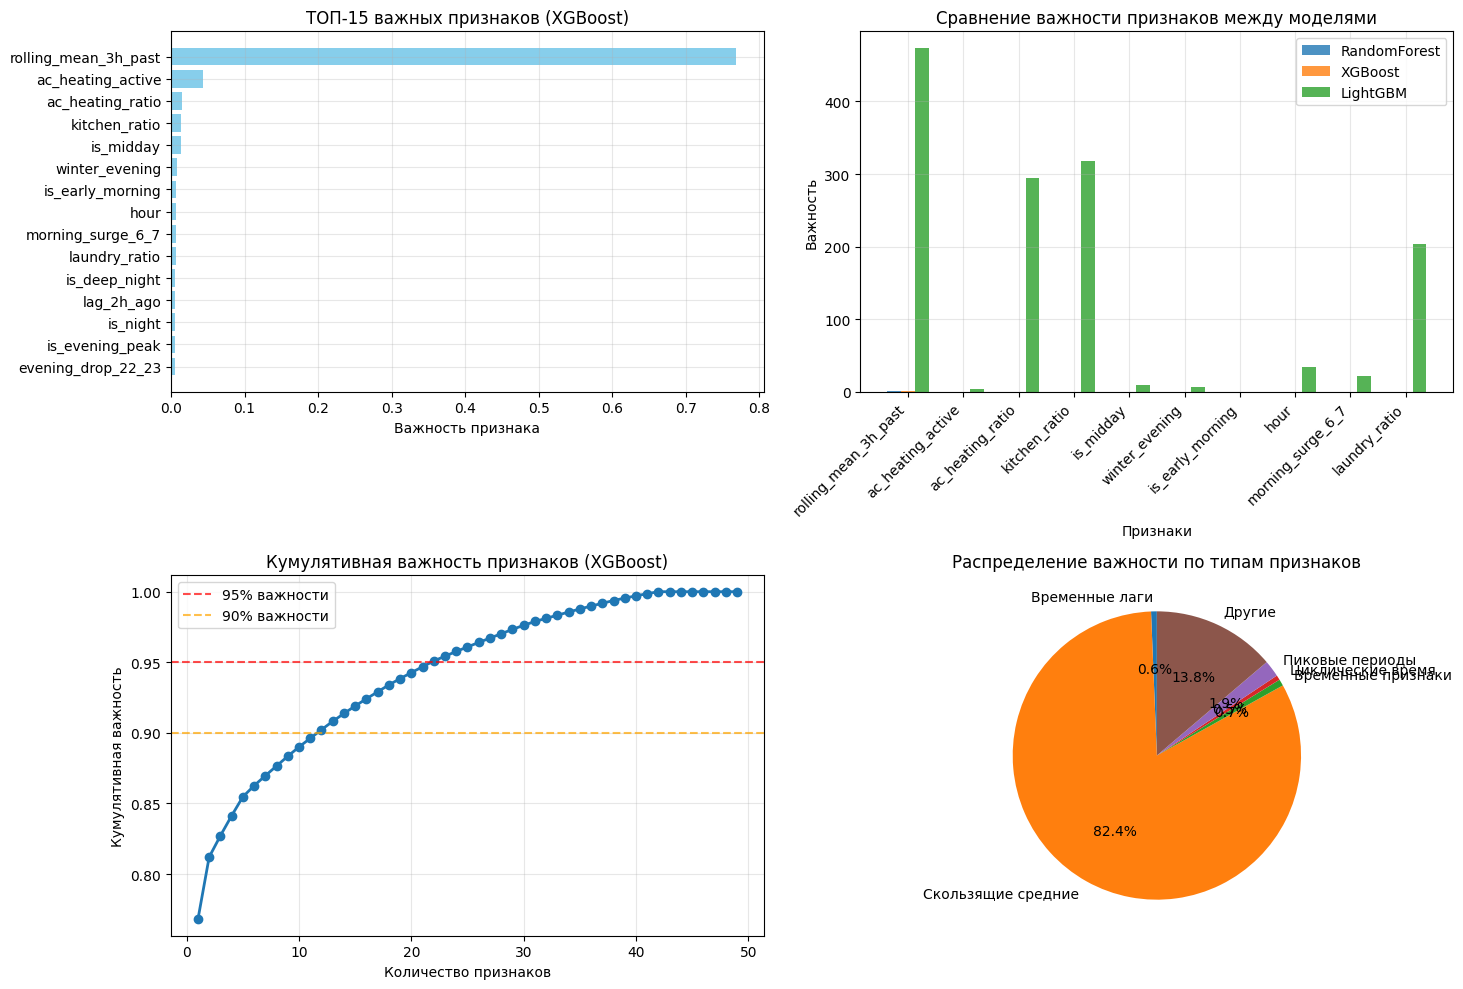


АНАЛИЗ КРИТИЧЕСКИХ ПРИЗНАКОВ
Признаков для 90% важности: 12
Признаков для 95% важности: 22
Всего признаков: 49

Самые важные признаки (топ-12):
  1. rolling_mean_3h_past
  2. ac_heating_active
  3. ac_heating_ratio
  4. kitchen_ratio
  5. is_midday
  6. winter_evening
  7. is_early_morning
  8. hour
  9. morning_surge_6_7
  10. laundry_ratio
  11. is_deep_night
  12. lag_2h_ago

ИНТЕРПРЕТАЦИЯ ЗАВЕРШЕНА! Критических признаков: 12


In [8]:
# ИНТЕРПРЕТАЦИЯ МОДЕЛЕЙ - ВАЖНОСТЬ ПРИЗНАКОВ
print("=" * 60)
print("ИНТЕРПРЕТАЦИЯ МОДЕЛЕЙ - АНАЛИЗ ВАЖНОСТИ ПРИЗНАКОВ")
print("=" * 60)

# Создаем DataFrame с важностью признаков для всех моделей
feature_importance_df = pd.DataFrame(index=safe_features)

# Для RandomForest
if hasattr(rf_model, 'feature_importances_'):
    feature_importance_df['RandomForest'] = rf_model.feature_importances_

# Для XGBoost
if hasattr(xgb_model, 'feature_importances_'):
    feature_importance_df['XGBoost'] = xgb_model.feature_importances_

# Для LightGBM
if hasattr(lgb_model, 'feature_importances_'):
    feature_importance_df['LightGBM'] = lgb_model.feature_importances_

# Сортируем по важности в XGBoost (лучшей модели)
feature_importance_df = feature_importance_df.sort_values('XGBoost', ascending=False)

print(f"\nТОП-15 самых важных признаков по версии {best_model}:")
print("=" * 50)
for i, (feature, importance) in enumerate(feature_importance_df['XGBoost'].head(15).items()):
    print(f"{i+1:2d}. {feature:<25} {importance:.4f} ({importance*100:.2f}%)")

# ВИЗУАЛИЗАЦИЯ ВАЖНОСТИ ПРИЗНАКОВ
plt.figure(figsize=(15, 10))

# График 1: Важность признаков для лучшей модели
plt.subplot(2, 2, 1)
top_features = feature_importance_df.head(15)
plt.barh(range(len(top_features)), top_features['XGBoost'], color='skyblue')
plt.yticks(range(len(top_features)), top_features.index)
plt.xlabel('Важность признака')
plt.title(f'ТОП-15 важных признаков ({best_model})')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3)

# График 2: Сравнение важности между моделями (ТОП-10)
plt.subplot(2, 2, 2)
top_10_features = feature_importance_df.head(10)
x = np.arange(len(top_10_features))
width = 0.25

plt.bar(x - width, top_10_features['RandomForest'], width, label='RandomForest', alpha=0.8)
plt.bar(x, top_10_features['XGBoost'], width, label='XGBoost', alpha=0.8)
plt.bar(x + width, top_10_features['LightGBM'], width, label='LightGBM', alpha=0.8)

plt.xlabel('Признаки')
plt.ylabel('Важность')
plt.title('Сравнение важности признаков между моделями')
plt.xticks(x, top_10_features.index, rotation=45, ha='right')
plt.legend()
plt.grid(True, alpha=0.3)

# График 3: Кумулятивная важность признаков
plt.subplot(2, 2, 3)
cumulative_importance = np.cumsum(feature_importance_df['XGBoost'])
plt.plot(range(1, len(cumulative_importance) + 1), cumulative_importance, marker='o', linewidth=2)
plt.axhline(y=0.95, color='red', linestyle='--', alpha=0.7, label='95% важности')
plt.axhline(y=0.90, color='orange', linestyle='--', alpha=0.7, label='90% важности')
plt.xlabel('Количество признаков')
plt.ylabel('Кумулятивная важность')
plt.title(f'Кумулятивная важность признаков ({best_model})')
plt.legend()
plt.grid(True, alpha=0.3)

# График 4: Распределение типов важных признаков
plt.subplot(2, 2, 4)
top_20_features = feature_importance_df.head(20)

# Классифицируем признаки по типам (СНАЧАЛА создаем словарь)
feature_types = {
    'Временные лаги': [f for f in top_20_features.index if 'lag' in f],
    'Скользящие средние': [f for f in top_20_features.index if 'rolling' in f],
    'Временные признаки': [f for f in top_20_features.index if f in ['hour', 'day_of_week', 'month', 'is_weekend']],
    'Циклические время': [f for f in top_20_features.index if 'sin' in f or 'cos' in f],
    'Пиковые периоды': [f for f in top_20_features.index if 'peak' in f or 'night' in f],
    'Потребление по зонам': [f for f in top_20_features.index if 'Sub_metering' in f],
    'Энергетические': [f for f in top_20_features.index if f in ['Global_reactive_power', 'Voltage', 'Global_intensity']]
}

# Теперь добавляем "Другие" - все что не вошло в предыдущие категории
used_features = set()
for features in feature_types.values():
    used_features.update(features)
    
feature_types['Другие'] = [f for f in top_20_features.index if f not in used_features]

# Считаем важность по типам
type_importance = {}
for type_name, features in feature_types.items():
    if features:
        type_importance[type_name] = feature_importance_df.loc[features, 'XGBoost'].sum()

plt.pie(type_importance.values(), labels=type_importance.keys(), autopct='%1.1f%%', startangle=90)
plt.title('Распределение важности по типам признаков')

plt.tight_layout()
plt.show()

# АНАЛИЗ КРИТИЧЕСКИХ ПРИЗНАКОВ
print("\n" + "=" * 60)
print("АНАЛИЗ КРИТИЧЕСКИХ ПРИЗНАКОВ")
print("=" * 60)

# Сколько признаков нужно для 95% важности?
n_features_95 = np.argmax(cumulative_importance >= 0.95) + 1
n_features_90 = np.argmax(cumulative_importance >= 0.90) + 1

print(f"Признаков для 90% важности: {n_features_90}")
print(f"Признаков для 95% важности: {n_features_95}")
print(f"Всего признаков: {len(feature_importance_df)}")

print(f"\nСамые важные признаки (топ-{n_features_90}):")
critical_features = feature_importance_df.head(n_features_90).index.tolist()
for i, feature in enumerate(critical_features, 1):
    print(f"  {i}. {feature}")

print(f"\nИНТЕРПРЕТАЦИЯ ЗАВЕРШЕНА! Критических признаков: {len(critical_features)}")


АНАЛИЗ ОШИБОК ПРОГНОЗИРОВАНИЯ
Большие ошибки (> 0.05 кВт): 16692 (32.02%)

Характеристики периодов с большими ошибками:
Час дня:
hour
0      592
1      359
2      296
3      283
4      262
5      284
6      781
7      924
8      681
9      641
10     642
11     668
12     666
13     611
14     645
15     621
16     599
17     685
18     846
19    1199
20    1217
21    1322
22    1169
23     699
Name: count, dtype: int64

День недели:
  Пн: 1785 ошибок
  Вт: 2279 ошибок
  Ср: 2583 ошибок
  Чт: 1857 ошибок
  Пт: 2392 ошибок
  Сб: 2832 ошибок
  Вс: 2964 ошибок

Пиковые периоды:
  Вечерний пик: 5753 ошибок
  Утренний пик: 2246 ошибок
  Ночное время: 2076 ошибок


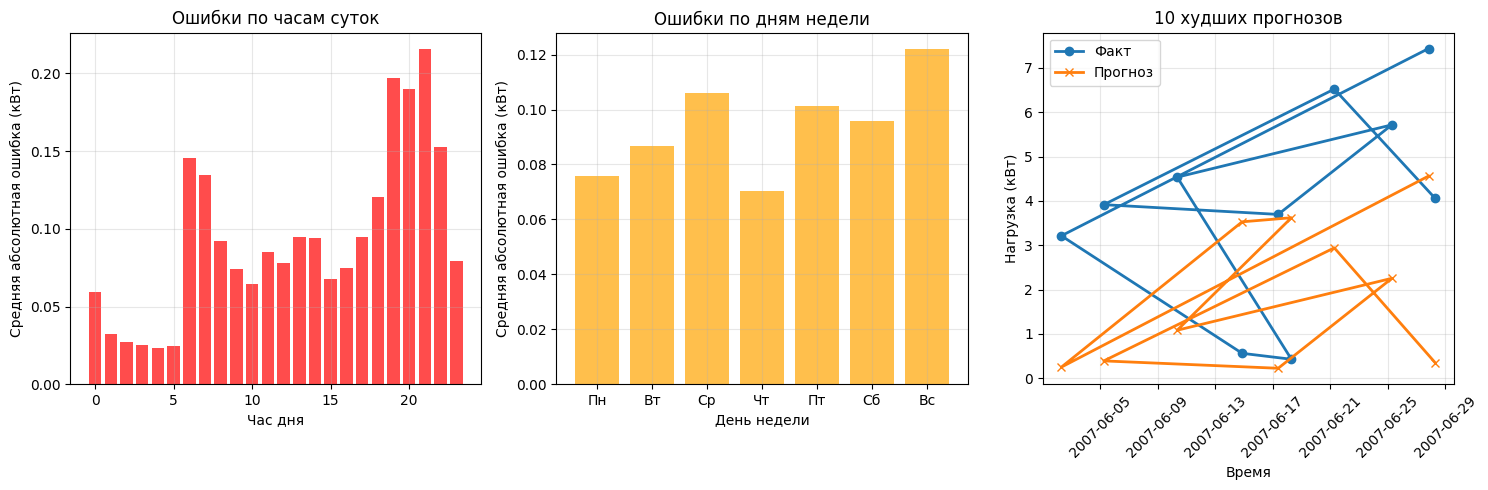

In [9]:
# АНАЛИЗ ОШИБОК ПРОГНОЗИРОВАНИЯ
print("\n" + "=" * 60)
print("АНАЛИЗ ОШИБОК ПРОГНОЗИРОВАНИЯ")
print("=" * 60)

# Берем прогнозы лучшей модели
y_pred_best = results[f'{best_model}']['predictions']  # Теперь лучшая модель RandomForest!
errors = y_pred_best - y_test.values

# Создаем Series с ошибками и правильными индексами
errors_series = pd.Series(errors, index=y_test.index)

# Анализ больших ошибок
error_threshold = 0.05  # 50 Вт - порог для "большой" ошибки
large_errors_mask = np.abs(errors) > error_threshold
large_errors_count = np.sum(large_errors_mask)
large_errors_percentage = (large_errors_count / len(errors)) * 100

print(f"Большие ошибки (> {error_threshold} кВт): {large_errors_count} ({large_errors_percentage:.2f}%)")

if large_errors_count > 0:
    # Анализ когда происходят большие ошибки
    large_errors_data = X_test[large_errors_mask]
    
    print("\nХарактеристики периодов с большими ошибками:")
    print("Час дня:")
    print(large_errors_data['hour'].value_counts().sort_index())
    
    print("\nДень недели:")
    day_names = {0: 'Пн', 1: 'Вт', 2: 'Ср', 3: 'Чт', 4: 'Пт', 5: 'Сб', 6: 'Вс'}
    day_counts = large_errors_data['day_of_week'].value_counts().sort_index()
    for day, count in day_counts.items():
        print(f"  {day_names[day]}: {count} ошибок")
    
    print(f"\nПиковые периоды:")
    print(f"  Вечерний пик: {large_errors_data['is_evening_peak'].sum()} ошибок")
    print(f"  Утренний пик: {large_errors_data['is_morning_peak'].sum()} ошибок")
    print(f"  Ночное время: {large_errors_data['is_night'].sum()} ошибок")

# ВИЗУАЛИЗАЦИЯ ОШИБОК
plt.figure(figsize=(15, 5))

# График 1: Распределение ошибок по времени суток
plt.subplot(1, 3, 1)
# ИСПРАВЛЕНИЕ: убираем ['Global_active_power'] - его нет в X_test
hourly_errors = X_test.groupby('hour').apply(
    lambda x: np.mean(np.abs(errors_series[x.index])), include_groups=False
)
plt.bar(hourly_errors.index, hourly_errors.values, alpha=0.7, color='red')
plt.xlabel('Час дня')
plt.ylabel('Средняя абсолютная ошибка (кВт)')
plt.title('Ошибки по часам суток')
plt.grid(True, alpha=0.3)

# График 2: Ошибки по дням недели  
plt.subplot(1, 3, 2)
# ИСПРАВЛЕНИЕ: убираем ['Global_active_power']
daily_errors = X_test.groupby('day_of_week').apply(
    lambda x: np.mean(np.abs(errors_series[x.index])), include_groups=False
)
plt.bar(daily_errors.index, daily_errors.values, alpha=0.7, color='orange')
plt.xlabel('День недели')
plt.ylabel('Средняя абсолютная ошибка (кВт)')
plt.title('Ошибки по дням недели')
plt.xticks(range(7), ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'])
plt.grid(True, alpha=0.3)

# График 3: Факт vs Прогноз для худших случаев
plt.subplot(1, 3, 3)
worst_indices = np.argsort(np.abs(errors))[-10:]  # 10 худших прогнозов
worst_times = y_test.iloc[worst_indices].index

plt.plot(worst_times, y_test.iloc[worst_indices], 'o-', label='Факт', linewidth=2)
plt.plot(worst_times, y_pred_best[worst_indices], 'x-', label='Прогноз', linewidth=2)
plt.xlabel('Время')
plt.ylabel('Нагрузка (кВт)')
plt.title('10 худших прогнозов')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()